In [2]:
from google.colab import files
import numpy as np
import pandas as pd
import itertools
import io
import timeit

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt

In [3]:
#%tensorflow_version 2.x
#import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1rJUCyDztqA321Uo690atZCQYS8Q1Y6XN"})
downloaded.GetContentFile('preprocessed_data.csv')
data_ready = pd.read_csv('preprocessed_data.csv')

In [34]:
def create_nn_model(dropout_rate=0.0, lam_l2=1e-3, learn_rate=1e-3, nlayers=5, nclass=3):
    # create model
    model = Sequential(name="Neural_network")
    for i in range(nlayers):
        model.add(layers.Dense(8*(nlayers-i), kernel_regularizer=l2(lam_l2), bias_regularizer=l2(lam_l2), input_dim=input_dim, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(nclass, activation='softmax'))
    optimizer = keras.optimizers.Adam(learn_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x[:-1], acc[1:], 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x[:-1], loss[1:], 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [31]:
# define the grid search parameters
#batch_size
cand_bs = [512, 2048, 4096]
#dropout rate
cand_dr = [0, 0.3]
#regularization
cand_l2 = [0, 1e-1]
#learning rate
#cand_lr = [1e-4, 1e-3, 1e-2]
#layers number
cand_ln = [10, 5, 1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  del sys.path[0]


In [6]:
#print(data_ready['category'].value_counts())
cat_index = data_ready['category'].value_counts().index

In [7]:
select_data = data_ready[data_ready['category'].isin(cat_index[0:3])].dropna().reset_index(drop=True)
print(select_data['category'].value_counts())

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"], random_state = 1000,
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

X_train.sort_indices()
X_test.sort_indices()
y_train.sort_indices()
y_test.sort_indices()

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

input_dim = X_train.shape[1]  # Number of features

model = KerasClassifier(build_fn=create_nn_model, epochs=25, verbose=0, nclass=3)

hep-ph      50603
quant-ph    44678
hep-th      39013
Name: category, dtype: int64


Tune hyperparameters through cross-validation

In [ ]:
#1 hidden layer

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[2:3])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 1 hidden layer: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results0 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#5 hidden layers

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[1:2])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 5 hidden layers: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results1 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#10 hidden layers

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[0:1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 10 hidden layers: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results2 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

Summarizing results

In [16]:
cv_results = pd.concat([cv_results0, cv_results1, cv_results2]).sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                 'split2_test_score', 'split3_test_score', 'split4_test_score'], 1, inplace = True)
clist = list(cv_results.columns.values)
cv_results_set0_nn = cv_results[clist[-2:] + clist[:-2]]
cv_results_set0_nn.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,mean_test_score,std_test_score,mean_fit_time,mean_score_time,param_batch_size,param_dropout_rate,param_lam_l2,param_nlayers
0,0.952874,0.001265,19.606653,0.304203,2048,0,0,1
1,0.952306,0.000999,30.247239,0.404164,512,0.3,0,1
2,0.952138,0.001662,19.316914,0.307041,2048,0.3,0,1
3,0.949970,0.001091,17.742523,0.295999,4096,0,0,1
4,0.949691,0.001238,17.625663,0.291132,4096,0.3,0,1
5,0.949458,0.001305,31.011815,0.407232,512,0,0,1
6,0.948024,0.000967,20.128936,0.366224,4096,0.3,0,5
7,0.947494,0.000751,21.458816,0.370651,2048,0.3,0,5
8,0.946442,0.000590,33.377254,0.460079,512,0.3,0,5
9,0.942626,0.001271,38.406523,0.533708,512,0,0,10


In [17]:
cv_results_set0_nn.to_csv('cv_results_set0_nn.csv', encoding = 'utf-8-sig') 
files.download('cv_results_set0_nn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training the best model on the whole training set

In [ ]:
clear_session()

model = create_nn_model(dropout_rate=0, lam_l2=0, learn_rate=1e-3, nlayers=1)
model.summary()

In [ ]:
history = model.fit(X_train, dummy_y_train, epochs=50, verbose=True, validation_data=(X_test, dummy_y_test),
                    batch_size=2048)

In [20]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9851
Testing Accuracy:  0.9529


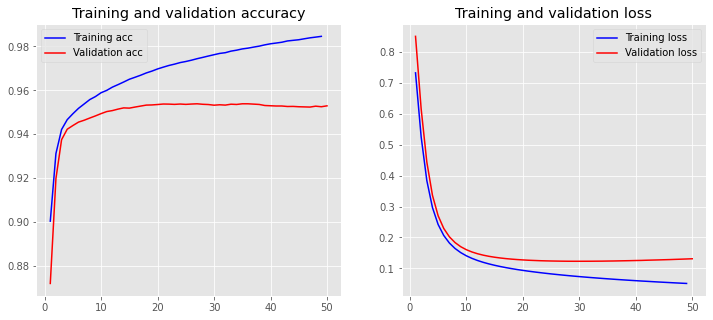

In [21]:
plt.style.use('ggplot')
   
plot_history(history)

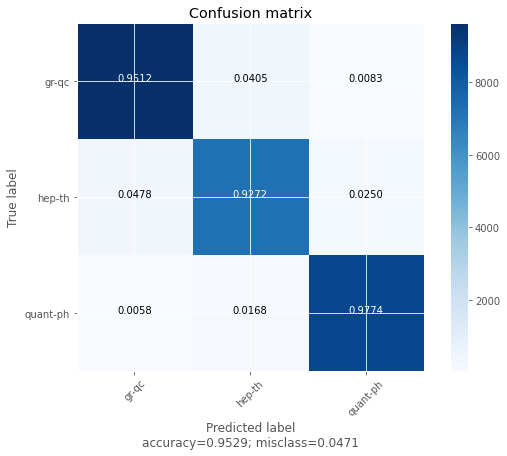

In [24]:
test_predicted_prob = model.predict(X_test)
test_predicted_classes = test_predicted_prob.argmax(1)

#Confusion matrix
conf = confusion_matrix(encoded_y_test, test_predicted_classes)
le_name_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
class_codes = [le_name_mapping[i] for i in range(3)]
plot_confusion_matrix(conf, class_codes)

Set 1

In [35]:
select_data = data_ready[data_ready['category'].isin(cat_index[4:9])].reset_index(drop=True)
print(select_data['category'].value_counts())

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"], random_state = 1000,
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

X_train.sort_indices()
X_test.sort_indices()
y_train.sort_indices()
y_test.sort_indices()

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

input_dim = X_train.shape[1]  # Number of features

model = KerasClassifier(build_fn=create_nn_model, epochs=25, verbose=0, nclass=5)

stat       19868
math-ph    17597
nucl-th    13730
q-bio      13316
hep-ex     10158
Name: category, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
#1 hidden layer

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[2:3])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 1 hidden layer: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results0 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#5 hidden layers

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[1:2])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 5 hidden layers: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results1 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#10 hidden layers

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[0:1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 10 hidden layers: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results2 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [41]:
cv_results = pd.concat([cv_results0, cv_results1, cv_results2]).sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                 'split2_test_score', 'split3_test_score', 'split4_test_score'], 1, inplace = True)
clist = list(cv_results.columns.values)
cv_results_set1_nn = cv_results[clist[-2:] + clist[:-2]]
cv_results_set1_nn.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,mean_test_score,std_test_score,mean_fit_time,mean_score_time,param_batch_size,param_dropout_rate,param_lam_l2,param_nlayers
0,0.956541,0.000583,25.060851,0.310192,512,0.3,0,1
1,0.956458,0.000975,26.447002,0.310058,512,0,0,1
2,0.953428,0.000616,13.995536,0.321429,2048,0,0,1
3,0.950632,0.001647,13.851811,0.241693,2048,0.3,0,1
4,0.949628,0.003069,14.739215,0.305614,2048,0.3,0,5
5,0.945426,0.003077,24.351287,0.433355,512,0.3,0,5
6,0.944756,0.002685,25.359168,0.353253,512,0,0,5
7,0.943400,0.006133,14.362242,0.299939,2048,0,0,5
8,0.942295,0.006324,12.511711,0.235048,4096,0.3,0,1
9,0.941157,0.004503,13.344885,0.240714,4096,0,0,1


In [42]:
cv_results_set1_nn.to_csv('cv_results_set1_nn.csv', encoding = 'utf-8-sig') 
files.download('cv_results_set1_nn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
clear_session()

model = create_nn_model(dropout_rate=0.3, lam_l2=0, learn_rate=1e-3, nlayers=1, nclass=5)
model.summary()

Model: "Neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 491336    
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 491,381
Trainable params: 491,381
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(X_train, dummy_y_train, epochs=50, verbose=True, validation_data=(X_test, dummy_y_test), batch_size=512)

loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


117/117 [==============================] - 2s 10ms/step - loss: 1.3926 - accuracy: 0.5412 - val_loss: 1.1397 - val_accuracy: 0.8354
Epoch 2/50
117/117 [==============================] - 1s 8ms/step - loss: 0.9783 - accuracy: 0.7508 - val_loss: 0.7231 - val_accuracy: 0.9277
Epoch 3/50
117/117 [==============================] - 2s 11ms/step - loss: 0.7063 - accuracy: 0.8012 - val_loss: 0.4798 - val_accuracy: 0.9423
Epoch 4/50
117/117 [==============================] - 1s 8ms/step - loss: 0.5661 - accuracy: 0.8291 - val_loss: 0.3546 - val_accuracy: 0.9468
Epoch 5/50
117/117 [==============================] - 1s 8ms/step - loss: 0.4861 - accuracy: 0.8440 - val_loss: 0.2864 - val_accuracy: 0.9501
Epoch 6/50
117/117 [==============================] - 1s 8ms/step - loss: 0.4325 - accuracy: 0.8578 - val_loss: 0.2439 - val_accuracy: 0.9520
Epoch 7/50
117/117 [==============================] - 1s 8ms/step - loss: 0.4007 - accuracy: 0.8626 - val_loss: 0.2169 - val_accuracy: 0.9549
Epoch 8/50
117/

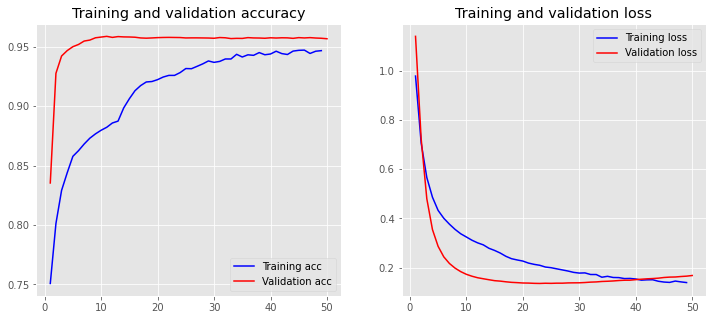

In [48]:
plt.style.use('ggplot')
   
plot_history(history)

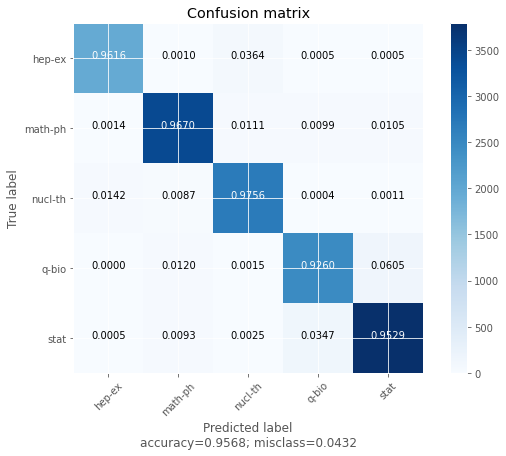

In [74]:
test_predicted_prob = model.predict(X_test)
test_predicted_classes = test_predicted_prob.argmax(1)

#Confusion matrix
conf = confusion_matrix(encoded_y_test, test_predicted_classes)
le_name_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
class_codes = [le_name_mapping[i] for i in range(5)]
plot_confusion_matrix(conf, class_codes)